In [1]:
import kan
import kan.utils as ku
import numpy as np
import torch.nn as nn
import torch
import qutip as qt
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions

In [2]:
N=8; J1=1; J2=0

In [3]:
def autocorrelation(x):
    """
    Compute the circular autocorrelation of +/-1 sequence x.
    x: 1D numpy array of length L with elements +1 or -1.
    Returns: numpy array A of length L, A[k] = sum_j x[j]*x[(j+k)%L].
    """
    L = len(x)
    A = np.zeros(L, dtype=int)
    for k in range(L):
        s = 0
        for j in range(L):
            s += x[j] * x[(j + k) % L]
        A[k] = s
    return A

def walsh_hadamard_transform(x):
    """
    Compute the Walsh-Hadamard transform (WHT) of input vector x.
    Length of x must be a power of two.
    Returns: numpy array of same length as x.
    """
    L = len(x)
    if L == 1:
        return x
    else:
        x = np.array(x)
        if (L & (L - 1)) != 0:
            raise ValueError("Length of input must be a power of two")
        half = L // 2
        top = walsh_hadamard_transform(x[:half])
        bottom = walsh_hadamard_transform(x[half:])
        return np.concatenate([top + bottom, top - bottom])

def auto_wht(bitstring):
    """
    Given a bitstring (list or array of 0/1), compute autocorrelation + WHT.
    Returns: numpy array of WHT of autocorrelation vector.
    """
    # Convert bitstring to +1/-1 sequence
    x = np.array([1 if b == 0 else -1 for b in bitstring])
    A = autocorrelation(x)
    T = walsh_hadamard_transform(A)
    return T

In [4]:
states = utils.generate_input_torch(N)
states = (-1) ** states.numpy()

In [5]:
auto_states = []
for i in range(len(states)):
    auto_states.append(autocorrelation(states[i]))
auto_states = np.array(auto_states)
auto_states

array([[8, 8, 8, ..., 8, 8, 8],
       [8, 4, 4, ..., 4, 4, 4],
       [8, 4, 4, ..., 4, 4, 4],
       ...,
       [8, 4, 4, ..., 4, 4, 4],
       [8, 4, 4, ..., 4, 4, 4],
       [8, 8, 8, ..., 8, 8, 8]])

In [6]:
auto_states.shape

(256, 8)

In [7]:
auto_wht_states = auto_states.copy()
for i in range(len(auto_wht_states)):
    auto_wht_states[i] = walsh_hadamard_transform(auto_wht_states[i])
auto_wht_states

array([[64,  0,  0, ...,  0,  0,  0],
       [36,  4,  4, ...,  4,  4,  4],
       [36,  4,  4, ...,  4,  4,  4],
       ...,
       [36,  4,  4, ...,  4,  4,  4],
       [36,  4,  4, ...,  4,  4,  4],
       [64,  0,  0, ...,  0,  0,  0]])

In [8]:
torch.tensor([autocorrelation(x) for x in states])

C:\Users\taoha\AppData\Local\Temp\ipykernel_21360\3630804694.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  torch.tensor([autocorrelation(x) for x in states])


tensor([[8, 8, 8,  ..., 8, 8, 8],
        [8, 4, 4,  ..., 4, 4, 4],
        [8, 4, 4,  ..., 4, 4, 4],
        ...,
        [8, 4, 4,  ..., 4, 4, 4],
        [8, 4, 4,  ..., 4, 4, 4],
        [8, 8, 8,  ..., 8, 8, 8]])

In [9]:
auto_states

array([[8, 8, 8, ..., 8, 8, 8],
       [8, 4, 4, ..., 4, 4, 4],
       [8, 4, 4, ..., 4, 4, 4],
       ...,
       [8, 4, 4, ..., 4, 4, 4],
       [8, 4, 4, ..., 4, 4, 4],
       [8, 8, 8, ..., 8, 8, 8]])

In [10]:
auto_states[:, 0:5]

array([[8, 8, 8, 8, 8],
       [8, 4, 4, 4, 4],
       [8, 4, 4, 4, 4],
       ...,
       [8, 4, 4, 4, 4],
       [8, 4, 4, 4, 4],
       [8, 8, 8, 8, 8]])

In [11]:
auto_input = torch.tensor(auto_states[:, 1:5], dtype=torch.float32)
auto_wht_input = torch.tensor(auto_wht_states, dtype=torch.float32)
labels = torch.tensor([-1 + 2 * (magnetization.count_half_magnetization(i) % 2) for i in range(2 ** N)]).reshape((-1, 1))
print(auto_wht_input.shape, labels.shape)
auto_dataset = {'train_input': auto_input, 'train_label': labels, 'test_input': auto_input, 'test_label': labels}
auto_wht_dataset = {'train_input': auto_wht_input, 'train_label': labels, 'test_input': auto_wht_input, 'test_label': labels}

torch.Size([256, 8]) torch.Size([256, 1])


In [12]:
auto_model = kan.KAN(width = [4, N, 1, 1]) # this doesn't work
auto_model(auto_dataset['train_input']);
auto_model.fix_symbolic(2, 0, 0, 'tanh');
auto_model.symbolic_fun[2].affine = nn.Parameter(torch.tensor([[[1, 0, 1, 0]]], dtype=torch.float32), requires_grad=False)

checkpoint directory created: ./model
saving model version 0.0
r2 is 0.9978808760643005
saving model version 0.1


In [13]:
auto_model.fit(auto_dataset, steps=20, lamb=1e-3);

| train_loss: 7.07e-01 | test_loss: 7.07e-01 | reg: 6.94e+00 | : 100%|█| 20/20 [00:11<00:00,  1.76it

saving model version 0.2


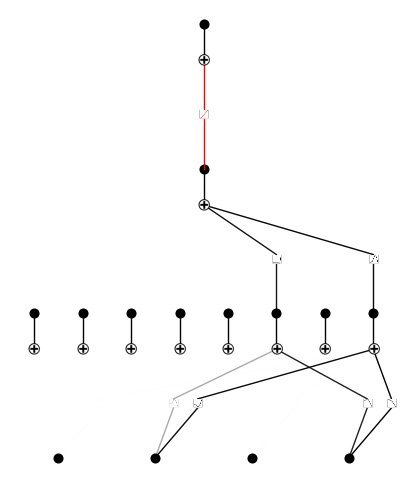

In [14]:
auto_model.plot()

In [15]:
auto_wht_model = kan.KAN(width = [N, N, 1, 1]) # this doesn't work
auto_wht_model(auto_wht_dataset['train_input']);
auto_wht_model.fix_symbolic(2, 0, 0, 'tanh');
auto_wht_model.symbolic_fun[2].affine = nn.Parameter(torch.tensor([[[1, 0, 1, 0]]], dtype=torch.float32), requires_grad=False)

checkpoint directory created: ./model
saving model version 0.0
r2 is 0.9979192614555359
saving model version 0.1


In [16]:
auto_wht_model.fit(auto_wht_dataset, steps=20, lamb=1e-3);

| train_loss: 7.07e-01 | test_loss: 7.07e-01 | reg: 1.49e+01 | : 100%|█| 20/20 [00:14<00:00,  1.39it

saving model version 0.2


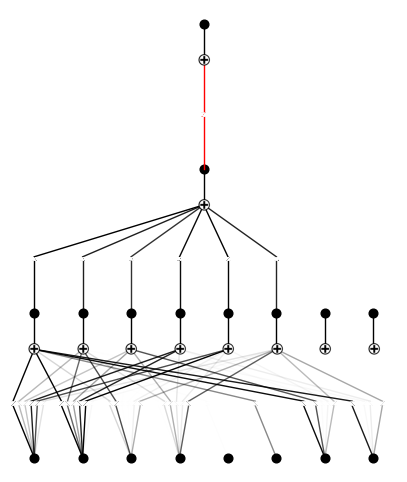

In [17]:
auto_wht_model.plot()

In [ ]:
torch.sqrt(torch.mean((auto_wht_model(auto_wht_dataset['train_input']) - auto_wht_dataset['train_label']) ** 2))

tensor(1., grad_fn=<SqrtBackward0>)

In [21]:
def rfft(x):
    x = (-1) ** np.array(x)
    return np.fft.rfft(x)[1:]
def psd(x):
    return np.abs(rfft(x)) ** 2
def norm_psd(x):
    vec = psd(x)
    return vec / np.linalg.norm(vec)

In [18]:
np.abs(1 + 1.j), np.angle(1 + 1.j)

(np.float64(1.4142135623730951), np.float64(0.7853981633974483))

In [23]:
-0.5 % np.pi

2.641592653589793

In [22]:
N=10; J1=1; J2=0 # try to learn MSR first

In [24]:
h10 = j1j2_functions.J1J2_hamiltonian(N, J1, J2)
eigs10 = h10.eigenstates()
gs10 = eigs10[1][0]
gs10

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape=(1024, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00]
 [ 1.26928255e-48]
 [-2.63794454e-18]
 ...
 [ 1.20393997e-48]
 [-2.12190686e-48]
 [ 0.00000000e+00]]

In [38]:
states, signs = utils.get_nonzero_states(N, gs10, 1e-10)
input = utils.generate_input_samples(N, states)
print(input.shape)
ft_input = []
for x in input:
    amp_phase = []
    ft = rfft(x)
    for c in ft:
        amp_phase.append(np.abs(c))
        amp_phase.append(np.angle(c) % (2 * np.pi))
    ft_input.append(amp_phase)
ft_input = torch.tensor(ft_input)
print(ft_input.shape)
msr_label = torch.tensor([magnetization.count_half_magnetization(s) for s in states]).reshape(-1, 1)
sign_label = torch.tensor(signs).reshape(-1, 1)
print(msr_label.shape, sign_label.shape)
msr_dataset = {'train_input':ft_input, 'train_label':msr_label, 'test_input':ft_input, 'test_label':msr_label}
sign_dataset = {'train_input':ft_input, 'train_label':sign_label, 'test_input':ft_input, 'test_label':sign_label}

torch.Size([252, 10])
torch.Size([252, 10])
torch.Size([252, 1]) torch.Size([252, 1])


C:\Users\taoha\AppData\Local\Temp\ipykernel_21360\915706225.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = (-1) ** np.array(x)


In [45]:
msr_model = kan.KAN([10, 5, 1])
msr_model.fit(msr_dataset, lamb=1e-2);

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 4.83e-02 | test_loss: 4.83e-02 | reg: 6.91e+00 | : 100%|█| 100/100 [00:24<00:00,  4.12

saving model version 0.1


In [46]:
msr_model.prune().width

saving model version 0.2


[[10, 0], [2, 0], [1, 0]]

In [47]:
msr_model = msr_model.prune()
msr_model.fit(msr_dataset, lamb=1e-3, steps=50);

saving model version 0.2


| train_loss: 9.52e-03 | test_loss: 9.52e-03 | reg: 4.16e+00 | : 100%|█| 50/50 [00:10<00:00,  4.55it

saving model version 0.3


In [48]:
msr_model.prune().width

saving model version 0.4


[[10, 0], [1, 0], [1, 0]]

In [49]:
msr_model = msr_model.prune()
msr_model.fit(msr_dataset, lamb=1e-3, steps=20);

saving model version 0.4


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 1.01e-02 | test_loss: 1.01e-02 | reg: 4.93e+00 | : 100%|█| 20/20 [00:03<00:00,  6.27it

saving model version 0.5


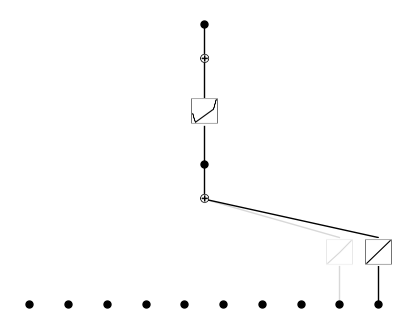

In [50]:
msr_model.plot()

In [55]:
torch.sqrt(torch.mean((msr_model(ft_input).round() - msr_label) ** 2))

tensor(0., grad_fn=<SqrtBackward0>)

In [56]:
msr_model.fix_symbolic(0, 9, 0, 'x');
msr_model.fix_symbolic(0, 8, 0, 'x');

r2 is 1.0000011920928955
saving model version 0.6
r2 is 0.9995018243789673
saving model version 0.7


In [57]:
msr_model.fit(msr_dataset, steps=20);

| train_loss: 9.00e-03 | test_loss: 9.00e-03 | reg: 3.08e+00 | : 100%|█| 20/20 [00:03<00:00,  5.57it

saving model version 0.8


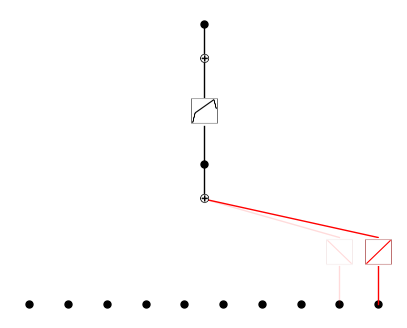

In [58]:
msr_model.plot()

    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        sin    0.999872 -12.820855           2                2   -8.374598
1        abs    0.999884 -12.951668           3                3   -8.166168
2        cos    0.999791 -12.159312           2                2   -7.911518
3        x^2    0.996242  -8.051889           2                2   -5.036322
4   gaussian    0.976024  -5.381676           3                3   -2.867173
5      1/x^2    0.962355  -4.731009           2                2   -2.711706
6        x^4    0.967658  -4.950014           3                3   -2.565010
7        exp    0.862749  -2.865009           2                2   -1.405506
8        1/x    0.852534  -2.761452           2                2   -1.333016
9  1/sqrt(x)    0.842239  -2.664092           2                2   -1.264864


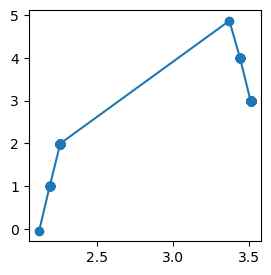

In [59]:
msr_model.get_fun(1, 0, 0);
msr_model.suggest_symbolic(1, 0, 0, topk=10, weight_simple=0.3);

In [60]:
msr_model.fix_symbolic(1, 0, 0, 'cos');
msr_model.fit(msr_dataset, steps=20);

r2 is 0.9997913837432861
saving model version 0.9


| train_loss: 1.12e-02 | test_loss: 1.12e-02 | reg: 0.00e+00 | : 100%|█| 20/20 [00:01<00:00, 19.62it

saving model version 0.10


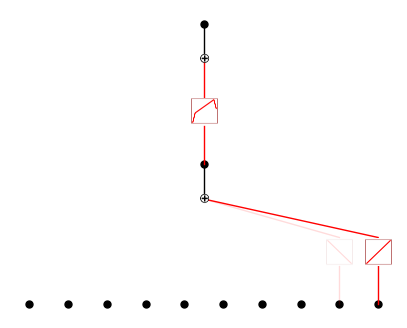

In [61]:
msr_model.plot()

In [62]:
ku.ex_round(msr_model.symbolic_formula()[0][0], 3)

1.58 - 6.47*cos(0.908*x_10 - 0.04*x_9 + 7.999)

In [63]:
msr_model(ft_input)

tensor([[ 3.0046],
        [ 2.0056],
        [ 3.0046],
        [ 2.0056],
        [ 3.0046],
        [ 2.0056],
        [ 3.0046],
        [ 3.9842],
        [ 3.0046],
        [ 3.9842],
        [ 3.0046],
        [ 3.0046],
        [ 2.0056],
        [ 3.0046],
        [ 2.0056],
        [ 3.0046],
        [ 3.9842],
        [ 3.0046],
        [ 3.0046],
        [ 2.0056],
        [ 3.0046],
        [ 2.0056],
        [ 3.0046],
        [ 2.0056],
        [ 3.0046],
        [ 2.0056],
        [ 2.0056],
        [ 0.9799],
        [ 2.0056],
        [ 0.9799],
        [ 2.0056],
        [ 3.0046],
        [ 2.0056],
        [ 2.0056],
        [ 0.9799],
        [ 2.0056],
        [ 3.0046],
        [ 2.0056],
        [ 3.0046],
        [ 2.0056],
        [ 3.0046],
        [ 3.9842],
        [ 3.0046],
        [ 3.0046],
        [ 2.0056],
        [ 3.0046],
        [ 2.0056],
        [ 3.0046],
        [ 2.0056],
        [ 2.0056],
        [ 0.9799],
        [ 2.0056],
        [ 3.

In [90]:
mult_kan = kan.KAN(width=[10, [0, 1]])
mult_kan.fit(msr_dataset, lamb=1e-3, steps=50);

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.29e-03 | test_loss: 8.29e-03 | reg: 2.88e+00 | : 100%|█| 50/50 [00:04<00:00, 11.83it

saving model version 0.1


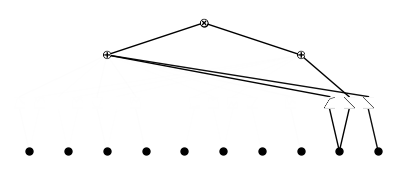

In [91]:
mult_kan.plot()

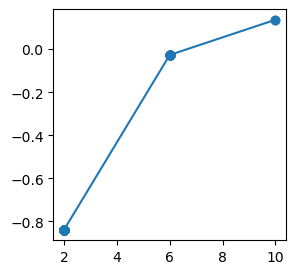

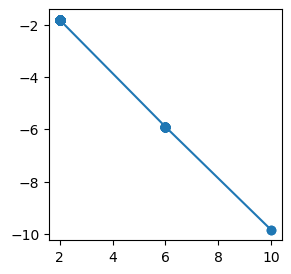

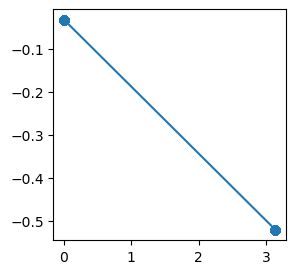

In [92]:
mult_kan.get_fun(0, 8, 0);
mult_kan.get_fun(0, 8, 1);
mult_kan.get_fun(0, 9, 0);

In [93]:
mult_kan.fix_symbolic(0, 8, 1, 'x');
mult_kan.fix_symbolic(0, 9, 0, 'x');

r2 is 0.999954104423523
saving model version 0.2
r2 is 1.000001072883606
saving model version 0.3


In [94]:
mult_kan.fit(msr_dataset, steps=20, lamb=1e-3);

| train_loss: 7.02e-03 | test_loss: 7.02e-03 | reg: 7.76e-01 | : 100%|█| 20/20 [00:04<00:00,  4.52it

saving model version 0.4


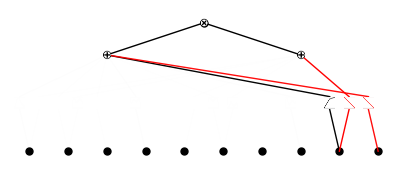

In [95]:
mult_kan.plot()

In [96]:
mult_kan.suggest_symbolic(0, 8, 0, topk=30, weight_simple=0.3);

     function  fitting r2    r2 loss  complexity  complexity loss  total loss
0         x^2    1.000001 -16.698301           2                2  -11.088811
1         1/x    1.000001 -16.698301           2                2  -11.088811
2         exp    1.000001 -16.698301           2                2  -11.088811
3         log    1.000001 -16.698301           2                2  -11.088811
4     1/x^0.5    1.000000 -16.680128           2                2  -11.076089
5   1/sqrt(x)    1.000000 -16.680128           2                2  -11.076089
6         sin    1.000000 -16.662180           2                2  -11.063526
7         cos    1.000000 -16.662180           2                2  -11.063526
8         x^3    1.000001 -16.716706           3                3  -10.801694
9         x^5    1.000001 -16.716706           3                3  -10.801694
10        abs    1.000001 -16.698301           3                3  -10.788811
11        tan    1.000001 -16.698301           3                

In [97]:
mult_kan.fix_symbolic(0, 8, 0, 'x');
mult_kan.fit(msr_dataset, steps=20);

Best value at boundary.
r2 is 0.9741042852401733
saving model version 0.5


| train_loss: 5.60e-02 | test_loss: 5.60e-02 | reg: 3.16e+00 | : 100%|█| 20/20 [00:04<00:00,  4.47it

saving model version 0.6


In [99]:
ku.ex_round(mult_kan.symbolic_formula()[0][0], 3)

1.0*(0.238 - 1.125*x_9)*(-0.135*x_10 + 0.138*x_9 - 1.248)

In [105]:
ku.ex_round(mult_kan.symbolic_formula()[0][0].expand(), 3)

0.152*x_10*x_9 - 0.032*x_10 - 0.155*x_9**2 + 1.437*x_9 - 0.297

In [ ]:
# we should have 1/4 * (-A[N/2] + N)
# translates to 1/4 * ((x9) * (x10 - pi/2) / (pi/2) + N)
# = 0.159 x9x10 - 0.25 * x9 + 2.5

In [143]:
sign_kan = kan.KAN(width=[10, 1, 1])
sign_kan.fit(sign_dataset, steps=50, lamb=1e-3);

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

| train_loss: 3.15e-03 | test_loss: 3.15e-03 | reg: 6.11e+00 | : 100%|█| 50/50 [00:05<00:00,  8.42it

saving model version 0.1


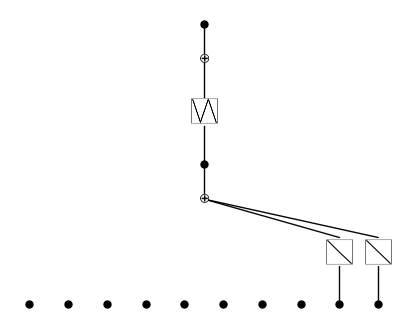

In [144]:
sign_kan.plot()

In [145]:
sign_kan.suggest_symbolic(0, 8, 0, topk=10, weight_simple=0.3);
sign_kan.suggest_symbolic(0, 9, 0, weight_simple=0.3);
sign_kan.suggest_symbolic(1, 0, 0, weight_simple=0.3);

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0      sin    1.000001 -16.716706           2                2  -11.101694
1      cos    1.000001 -16.716706           2                2  -11.101694
2    1/x^2    1.000001 -16.698301           2                2  -11.088811
3      exp    1.000001 -16.698301           2                2  -11.088811
4    x^0.5    1.000000 -16.644454           2                2  -11.051118
5     sqrt    1.000000 -16.644454           2                2  -11.051118
6      log    0.999998 -16.294214           2                2  -10.805950
7     tanh    1.000001 -16.716706           3                3  -10.801694
8      x^5    1.000001 -16.698301           3                3  -10.788811
9      abs    1.000001 -16.698301           3                3  -10.788811
  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        x    1.000001 -16.773374           1                1  -11.441362
1      1/x    1.000001 -1

In [146]:
sign_kan.fix_symbolic(1, 0, 0, 'cos');
sign_kan.fix_symbolic(0, 9, 0, 'x');
sign_kan.fix_symbolic(0, 8, 0, 'x');

r2 is 1.0000001192092896
saving model version 0.2
r2 is 1.000001072883606
saving model version 0.3
r2 is 0.9998852610588074
saving model version 0.4


In [147]:
sign_kan.fit(sign_dataset, steps=20);

| train_loss: 2.45e-06 | test_loss: 2.45e-06 | reg: 4.71e-02 | : 100%|█| 20/20 [00:01<00:00, 13.50it

saving model version 0.5


In [148]:
ku.ex_round(sign_kan.symbolic_formula()[0][0], 3)
# this is pretty good, changing x10 from 0->pi flips sign, increasing x9 by 4 flips sign.

1.0*cos(1.0*x_10 + 0.785*x_9 + 1.579)

In [ ]:
# same as -sin(x10 + x9 * pi/4)

In [152]:
gs12 = qt.qload('../J1J2_info/N12/n12gs_J2_0.0')
gs12

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape=(4096, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00]
 [ 3.47816340e-52]
 [-1.52575097e-17]
 ...
 [ 7.24291764e-52]
 [ 1.94089486e-52]
 [ 0.00000000e+00]]